# **Fixed-wing Drone Proximal Policy Optimization**

In [1]:
############################### Import libraries ###############################
import os
import glob
import time
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np
from numpy import matlib

import gym
import pybullet_envs

(-0.5, 49.5, 19.5, -0.5)

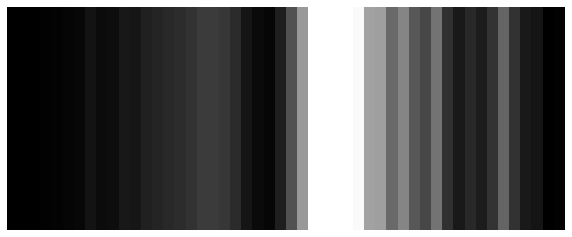

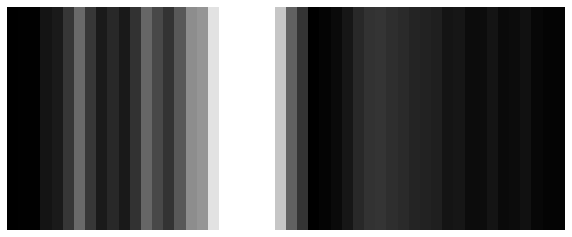

In [2]:
def camera(time,state,vel):
    def markers(pos_x,num):
        height = 20
        x = pos_x - np.floor(pos_x)
        points_x = x + np.arange(0,num)
        points_y = height*np.ones(num)
        points_z = np.ones(num)
        upper = np.vstack((points_x,points_y,points_z))
        lower = np.vstack((points_x,-points_y,points_z))
        points = np.hstack((upper,lower))
        return points

    def rotate(points,x,y,angle):
        rot = np.array([
            [np.cos(angle),np.sin(angle),0.0],
            [-np.sin(angle),np.cos(angle),-y],
            [0,0,1]
        ])
        new_points = np.dot(rot,points)
        return new_points

    def projection(points,focal):
        X = points[1,:]
        Z = points[0,:]
        x = focal*X/Z
        return x

    def intensity(points):
        r = np.linalg.norm(points[0:2,:],axis=0)
        I = 1000/(0.1+r**2)
        return I

    def coord2pixels(x,intensity):
        width = 50
        coord = np.round(x/0.001)
        image = np.zeros(width)
        for i in range(len(coord)):
            if abs(coord[i])<width/2-3:
                image[int(coord[i]+width/2)] += intensity[i]
                image[int(coord[i]+width/2)-1] += intensity[i]/2
                image[int(coord[i]+width/2)+1] += intensity[i]/2
                image[int(coord[i]+width/2)-2] += intensity[i]/4
                image[int(coord[i]+width/2)+2] += intensity[i]/4
                image[int(coord[i]+width/2)-3] += intensity[i]/5
                image[int(coord[i]+width/2)+3] += intensity[i]/5

        noise = abs(np.random.normal(0,0.1,(width,)))
        image += noise
        image[image>20]=20
        image[image<0]=0
        return image
    
    pos_x = vel*time
    pos_y = state[3]
    theta = state[0]

    points = markers(pos_x,num=20)
    points = rotate(points,pos_x,pos_y,theta)
    x = projection(points,focal=0.0035)
    I = intensity(points)
    image = coord2pixels(x,I)

    return image

image = camera(1,[np.random.uniform(-0.2,0.2),0,0,np.random.uniform(-10,10)],np.random.uniform(0,1))
image = np.matlib.repmat(image,20,1)
plt.figure(figsize=(10,5))
plt.imshow(image,cmap='gray')
plt.axis('off')

image = camera(1,[np.random.uniform(-0.2,0.2),0,0,np.random.uniform(-10,10)],np.random.uniform(0,1))
image = np.matlib.repmat(image,20,1)
plt.figure(figsize=(10,5))
plt.imshow(image,cmap='gray')
plt.axis('off')

# Choose cpu or GPU

In [3]:
################################## set device ##################################

# set device to cpu or cuda
device = torch.device('cpu')

# if(torch.cuda.is_available()): 
#     device = torch.device('cuda:0') 
#     torch.cuda.empty_cache()
#     print("Device set to : " + str(torch.cuda.get_device_name(device)))
# else:
#     print("Device set to : cpu")

# **Proximal Policy Optimization**

In [4]:
################################## PPO Policy ##################################

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        dim_layer = 128
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, dim_layer),
                            nn.LeakyReLU(),
                            nn.Linear(dim_layer, dim_layer),
                            nn.LeakyReLU(),
                            nn.Linear(dim_layer, action_dim),
                            nn.LeakyReLU()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, dim_layer),
                            nn.LeakyReLU(),
                            nn.Linear(dim_layer, dim_layer),
                            nn.LeakyReLU(),
                            nn.Linear(dim_layer, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, dim_layer),
                        nn.LeakyReLU(),
                        nn.Linear(dim_layer, dim_layer),
                        nn.LeakyReLU(),
                        nn.Linear(dim_layer, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        

# **Create drone environment**

In [5]:
class Drone():
    def __init__(self):
        self.A = np.array([
            [0.6, 0.0, .15, 0.0],
            [-0.1, 1.0, 0.2, 0.0],
            [-0.9, 0.0, 0.5, 0.0],
            [-27.5, 32.0, 0.4, 1.0]
        ])
        self.B = np.array([
            [-0.4],
            [-0.4],
            [-3.2],
            [0.6]
        ])

        self.alpha_thres = np.pi/4
        self.pitch_thes = np.pi/4
        self.pitch_rate_thres = np.pi
        self.alt_thres = 10.0

        self.limits = np.array([
            self.alpha_thres,
            self.pitch_thes,
            self.pitch_rate_thres,
            self.alt_thres
        ])

        self.action_space = gym.spaces.Discrete(31)
        dim = 100
        # self.observation_space = gym.spaces.Box(-self.limits,self.limits)
        self.observation_space = gym.spaces.Box(np.zeros(dim),20*np.ones(dim))

        self.state = None
        self.prev_action = 0
        self.steps_beyond_terminated = None
        self.prev_image = np.zeros(dim)

        self.time = 0
        self.vel = 5.1

    def camera(self):
        def markers(pos_x,num):
            height = 20
            x = pos_x - np.floor(pos_x)
            points_x = x + np.arange(0,num)
            points_y = height*np.ones(num)
            points_z = np.ones(num)
            upper = np.vstack((points_x,points_y,points_z))
            lower = np.vstack((points_x,-points_y,points_z))
            points = np.hstack((upper,lower))
            return points

        def rotate(points,x,y,angle):
            rot = np.array([
                [np.cos(angle),np.sin(angle),0.0],
                [-np.sin(angle),np.cos(angle),-y],
                [0,0,1]
            ])
            new_points = np.dot(rot,points)
            return new_points

        def projection(points,focal):
            X = points[1,:]
            Z = points[0,:]
            x = focal*X/Z
            return x

        def intensity(points):
            r = np.linalg.norm(points[0:2,:],axis=0)
            I = 1000/(0.1+r**2)
            return I

        def coord2pixels(x,intensity):
            width = 50
            coord = np.round(x/0.001)
            image = np.zeros(width)
            for i in range(len(coord)):
                if abs(coord[i])<width/2-3:
                    image[int(coord[i]+width/2)] += intensity[i]
                    image[int(coord[i]+width/2)-1] += intensity[i]/2
                    image[int(coord[i]+width/2)+1] += intensity[i]/2
                    image[int(coord[i]+width/2)-2] += intensity[i]/4
                    image[int(coord[i]+width/2)+2] += intensity[i]/4
                    image[int(coord[i]+width/2)-3] += intensity[i]/5
                    image[int(coord[i]+width/2)+3] += intensity[i]/5

            noise = abs(np.random.normal(0,0.1,(50,)))
            image += noise
            image[image>20]=20
            image[image<0]=0
            return image
        
        v = self.vel + np.random.uniform(-0.1,0.1)
        pos_x = v*self.time
        pos_y = self.state[3]
        theta = self.state[0]

        points = markers(pos_x,num=20)
        points = rotate(points,pos_x,pos_y,theta)
        x = projection(points,focal=0.0035)
        I = intensity(points)
        image = coord2pixels(x,I)

        return image
    
    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        
        self.time += 1

        action -= (self.action_space.n-1)/2
        action = 2*action/(self.action_space.n-1)
        action = action*15*np.pi/180
        
        noise = np.random.normal(0,0.01,(4,1))
        state = np.dot(self.A,np.reshape(self.state,(4,1))) + self.B*action + noise

        alpha = state[0]
        pitch = state[1]
        pitch_rate = state[2]
        alt = state[3]
        self.state = (list(np.reshape(state,(4,))))

        terminated = bool(
            alpha < -self.alpha_thres
            or alpha > self.alpha_thres
            or pitch < -self.pitch_thes
            or pitch > self.pitch_thes
            or pitch_rate < -self.pitch_rate_thres
            or pitch_rate > self.pitch_rate_thres
            or alt < -self.alt_thres
            or alt > self.alt_thres
        )

        if not terminated:
            # reward = self.alt_thres**2 - alt**2 - abs(action-self.prev_action)
            reward = 30 - 180/np.pi*abs(action-self.prev_action)
            reward = int(np.round(reward))
        elif self.steps_beyond_terminated is None:
            self.steps_beyond_terminated = 0
            reward = 0.0
        else:
            if self.steps_beyond_terminated == 0:
                gym.logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        self.prev_action = action
        self.prev_image[0:50] = self.prev_image[50:100]
        self.prev_image[50:100] = self.camera()

        return self.prev_image, reward, terminated, False

    def reset(self):
        self.state = np.random.uniform(-0.05,0.05,(4,))
        self.prev_action = 0
        self.steps_beyond_terminated = None
        self.time = 0

        return np.zeros(100)

    def close(self):
        pass

# **Test the Policy**

In [6]:
#################################### Testing ###################################

def test_policy(env_name, total_test_episodes = 10, K_epochs = 40, hyper = [0.2, 0.0003, 0.001], gamma = 0.99, random_seed = 0, write_out=True):
    if write_out:
        print("============================================================================================")

    ################## hyperparameters ##################

    eps_clip = hyper[0]
    lr_actor = hyper[1]
    lr_critic = hyper[2]

    has_continuous_action_space = False
    max_ep_len = 333
    action_std = None


    #####################################################

    if env_name == "CartPole-v1":
        env = gym.make(env_name)
    else:
        env = Drone()

    # state space dimension
    state_dim = env.observation_space.shape[0]

    # action space dimension
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n


    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


    # preTrained weights directory
    random_seed = 0             #### set this to load a particular checkpoint trained on random seed
    run_num_pretrained = 0      #### set this to load a particular checkpoint num


    directory = "PPO_preTrained" + '/' + env_name + '/'
    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
    if write_out:
        print("loading network from : " + checkpoint_path)

    ppo_agent.load(checkpoint_path)

    if write_out:
        print("--------------------------------------------------------------------------------------------")


    test_running_reward = 0
    max_ep_reward = 0

    for ep in range(1, total_test_episodes+1):
        ep_reward = 0
        trajectory = []
        state = env.reset()
        
        for t in range(1, max_ep_len+1):
            action = ppo_agent.select_action(state)
            state, reward, done, _ = env.step(action)
            trajectory.append(tuple([env.state[0],env.state[1],env.state[2],env.state[3],action]))
            ep_reward += reward
            
            if done:
                break

        # clear buffer    
        ppo_agent.buffer.clear()

        test_running_reward +=  ep_reward
        if write_out:
            print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
        if ep_reward > max_ep_reward:
            max_ep_reward = ep_reward
        ep_reward = 0

    env.close()


    if write_out:
        print("============================================================================================")

    avg_test_reward = test_running_reward / total_test_episodes
    avg_test_reward = round(avg_test_reward, 2)
    max_ep_reward = round(max_ep_reward, 2)
    print("average test reward : " + str(avg_test_reward))
    print("max test reward : " + str(max_ep_reward))
    print("============================================================================================")
    
    return avg_test_reward, max_ep_reward, trajectory
    

# **Train the Agent**

In [18]:
################################### Training ###################################

def train_agent(env_name, K_epochs = 40, hyper = [0.2, 0.0003, 0.001], gamma = 0.99, random_seed = 0, write_out=True):
    
    ####### initialize environment hyperparameters ######

    has_continuous_action_space = False

    max_ep_len = 333                    # max timesteps in one episode
    max_training_timesteps = int(5e4)   # break training loop if timeteps > max_training_timesteps

    print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
    log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
    save_model_freq = int(5e4)      # save model frequency (in num timesteps)

    action_std = None


    #####################################################


    ## Note : print/log frequencies should be > than max_ep_len


    ################ PPO hyperparameters ################
    eps_clip = hyper[0]
    lr_actor = hyper[1]
    lr_critic = hyper[2]

    update_timestep = max_ep_len * 4      # update policy every n timesteps

    hyper = {"update_timestep":update_timestep,"K_epochs":K_epochs,"eps_clip":eps_clip,"gamma":gamma,"lr_actor":lr_actor,"lr_critic":lr_critic,"random_seed":random_seed}
    #####################################################


    print("training environment name : " + env_name)

    if env_name == "CartPole-v1":
        env = gym.make(env_name)
    else:
        env = Drone()

    # state space dimension
    state_dim = env.observation_space.shape[0]

    # action space dimension
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n


    ###################### logging ######################

    #### log files for multiple runs are NOT overwritten

    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)


    #### get number of log files in log directory
    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)


    #### create new log file for each run 
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

    if write_out:
        print("current logging run number for " + env_name + " : ", run_num)
        print("logging at : " + log_f_name)

    #####################################################


    ################### checkpointing ###################

    run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)


    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
    if write_out:
        print("save checkpoint path : " + checkpoint_path)

    #####################################################


    ############# print all hyperparameters #############

    if write_out:
        print("--------------------------------------------------------------------------------------------")

        print("max training timesteps : ", max_training_timesteps)
        print("max timesteps per episode : ", max_ep_len)

        print("model saving frequency : " + str(save_model_freq) + " timesteps")
        print("log frequency : " + str(log_freq) + " timesteps")
        print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

        print("--------------------------------------------------------------------------------------------")

        print("state space dimension : ", state_dim)
        print("action space dimension : ", action_dim)

        print("--------------------------------------------------------------------------------------------")

        if has_continuous_action_space:
            print("Initializing a continuous action space policy")
            print("--------------------------------------------------------------------------------------------")
            print("starting std of action distribution : ", action_std)
            print("decay rate of std of action distribution : ", action_std_decay_rate)
            print("minimum std of action distribution : ", min_action_std)
            print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

        else:
            print("Initializing a discrete action space policy")

        print("--------------------------------------------------------------------------------------------")

        print("PPO update frequency : " + str(update_timestep) + " timesteps") 
        print("PPO K epochs : ", K_epochs)
        print("PPO epsilon clip : ", eps_clip)
        print("discount factor (gamma) : ", gamma)

        print("--------------------------------------------------------------------------------------------")

        print("optimizer learning rate actor : ", lr_actor)
        print("optimizer learning rate critic : ", lr_critic)

    if random_seed:
        if write_out:
            print("--------------------------------------------------------------------------------------------")
            print("setting random seed to ", random_seed)
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)

    #####################################################

    if write_out:
        print("============================================================================================")

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("============================================================================================")


    # logging file
    log_f = open(log_f_name,"w+")
    log_f.write('episode,timestep,reward,')
    for i,j in enumerate(hyper):
        log_f.write(str(j)+",")
    log_f.write('\n')


    # printing and logging variables
    print_running_reward = 0
    print_running_episodes = 0

    log_running_reward = 0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0


    # training loop
    combined_reward = 0
    while time_step <= max_training_timesteps:
        
        state = env.reset()
        current_ep_reward = 0

        for t in range(1, max_ep_len+1):
            
            # select action with policy
            action = ppo_agent.select_action(state)
            state, reward, done, _ = env.step(action)
            
            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)
            
            time_step +=1
            current_ep_reward += reward

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # log in logging file
            if time_step % log_freq == 0:

                # log average reward till last episode
                log_avg_reward = log_running_reward / log_running_episodes
                log_avg_reward = round(log_avg_reward, 4)


                if time_step==log_freq:
                    log_f.write('{},{},{},'.format(i_episode, time_step, log_avg_reward))

                    for i,j in enumerate(hyper):
                        log_f.write(str(hyper[j])+",")
                    log_f.write('\n')
                else:
                    log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                
                log_f.flush()

                log_running_reward = 0
                log_running_episodes = 0

            # printing average reward
            if time_step % print_freq == 0:

                # print average reward till last episode
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                if write_out:
                    print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

                print_running_reward = 0
                print_running_episodes = 0
                
            # save model weights
            if time_step % save_model_freq == 0:
                print("--------------------------------------------------------------------------------------------")
                print("saving model at : " + checkpoint_path)
                ppo_agent.save(checkpoint_path)
                print("model saved")
                print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                avg_reward, max_ep_reward, _ = test_policy(env_name=env_name, total_test_episodes = 100, hyper=[eps_clip,lr_actor,lr_critic], write_out=False)
                # if (avg_reward+max_ep_reward/2) < combined_reward:
                #     time_step = max_training_timesteps+1
                #     print("Learning has stopped. Training is complete.")
                # else:
                #     combined_reward = avg_reward+max_ep_reward/2
                # print("Average Reward : ", avg_reward)
                # print("Maximum Ep. Reward : ", max_ep_reward)
                print("--------------------------------------------------------------------------------------------")
                
            # break; if the episode is over
            if done:
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1

        log_running_reward += current_ep_reward
        log_running_episodes += 1

        i_episode += 1


    log_f.close()
    env.close()

    # print total training time
    if write_out:
        print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    if write_out:
        print("Started training at (GMT) : ", start_time)
        print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")

    return


In [19]:
env_name="Drone"

eps_clip = 0.2              # clip parameter for PPO
lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

hyper = [eps_clip, lr_actor, lr_critic]

train_agent(env_name=env_name, hyper=hyper, write_out=False)

training environment name : Drone
Started training at (GMT) :  2022-12-12 06:36:53
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/Drone/PPO_Drone_0_0.pth
model saved
Elapsed Time  :  0:00:42
average test reward : 2076.35
max test reward : 7148
--------------------------------------------------------------------------------------------
Total training time  :  0:00:49


Sample a trajectory during testing

In [20]:
avg_test_reward, _, trajectory = test_policy(env_name=env_name, total_test_episodes = 1, hyper=hyper, write_out=False)

results3 = []
for i in range(100):
    avg_test_reward, _, trajectory = test_policy(env_name=env_name, total_test_episodes = 1, hyper=hyper, write_out=False)
    results3.append(avg_test_reward)
    pitch,alpha,alpha_dot,alt,elev = zip(*trajectory)

# plt.plot(5*np.arange(len(alt)),alt)
# plt.plot(5*np.arange(len(alt)),np.array(elev)-15)

/home/tsmorz/anaconda3/envs/ML/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


average test reward : 83.0
max test reward : 83.0
average test reward : 2654.0
max test reward : 2654.0
average test reward : 1422.0
max test reward : 1422.0
average test reward : 855.0
max test reward : 855.0
average test reward : 668.0
max test reward : 668.0
average test reward : 1792.0
max test reward : 1792.0
average test reward : 302.0
max test reward : 302.0
average test reward : 3789.0
max test reward : 3789.0
average test reward : 514.0
max test reward : 514.0
average test reward : 1006.0
max test reward : 1006.0
average test reward : 3007.0
max test reward : 3007.0
average test reward : 336.0
max test reward : 336.0
average test reward : 2734.0
max test reward : 2734.0
average test reward : 4283.0
max test reward : 4283.0
average test reward : 880.0
max test reward : 880.0
average test reward : 1682.0
max test reward : 1682.0
average test reward : 1315.0
max test reward : 1315.0
average test reward : 2848.0
max test reward : 2848.0
average test reward : 253.0
max test reward 

Text(0.5, 1.0, 'Reward Distribution over 100 Trials')

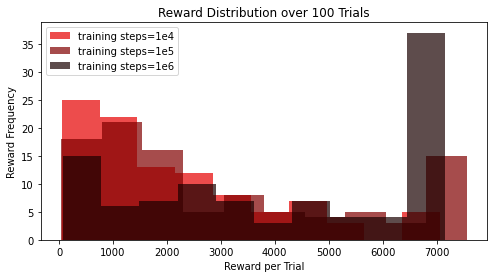

In [45]:
plt.figure(figsize=(8,4))
plt.hist(results3, color=[0.9, 0, 0, 0.7])
plt.hist(results, color=[0.5, 0, 0, 0.7])
plt.hist(results2, color=[0.1, 0, 0, 0.7])
plt.legend(['training steps=1e4','training steps=1e5','training steps=1e6'])
plt.xlabel('Reward per Trial')
plt.ylabel('Reward Frequency')
plt.title('Reward Distribution over 100 Trials')

In [ ]:
%matplotlib qt

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(5*np.arange(len(alt)),alt,c='blue')
plt.xlim([0,400])
plt.ylim([-10,10])
plt.ylabel('Drone Altitude (m)')


plt.subplot(212)
plt.plot(5*np.arange(len(alt)),np.array(elev)-15,c='orange')
plt.ylim([-15,15])
plt.xlim([0,400])
plt.ylabel('Elevator Angle (deg)')
plt.xlabel('time steps')

# **Hyperparameter Search**

## Uniform Search

In [ ]:
num = 4
results2 = []

eps_clip = np.linspace(0.2,0.6,num)       #0.2              # clip parameter for PPO
lr_actor = np.linspace(0.00005,0.0005,num) #0.0003       # learning rate for actor network
lr_critic = np.linspace(0.0005,0.005,num)    #0.001       # learning rate for critic network

print('eps_clip:',np.round(eps_clip,3),'\tlr_actor:',np.round(lr_actor,5),'\tlr_critic:',np.round(lr_critic,5))

for i in range(num):
    for j in range(num):
        for k in range(num):
            
            print('Trial:',i,j,k)

            hyper = [eps_clip[i], lr_actor[j], lr_critic[k]]
            train_agent(env_name="Drone", hyper=hyper, write_out=False)

            avg_test_reward,_,_ = test_policy(env_name="Drone", total_test_episodes = 100, hyper=hyper, write_out=False)
            results2.append([eps_clip[i], lr_actor[j], lr_critic[k], avg_test_reward])
            print()

results2 = np.array(results2)

In [ ]:
print(results2)

In [ ]:
ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
x = results2[:,0]
y = results2[:,1]
z = results2[:,2]
color = results2[:,3]/400
ax.scatter(x, y, z, zdir='z', c=color,cmap='cool',alpha=0.99)
ax.set_xlabel('eps clip')
ax.set_ylabel('lr actor')
ax.set_zlabel('lr critic')
offset = 0.0001
ax.set_xlim([min(eps_clip)-offset,max(eps_clip)+offset])
ax.set_ylim([min(lr_actor)-offset,max(lr_actor)+offset])
ax.set_zlim([min(lr_critic)-offset,max(lr_critic)+offset])
plt.show()

plt.hist(results2[:,3])

In [ ]:
idx = np.argmax(results2[:,-1])
m = results2[idx,:]
print(m)

In [ ]:
plt.hist(results[:,3],color='red',alpha=0.5,bins=10)
plt.hist(results2[:,3],color='blue',alpha=0.5,bins=10)
plt.show()

# **Part - III**

*   load log files using pandas
*   plot graph using matplotlib

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_test_results(env_name, write_out=False):
    if write_out:
            print("============================================================================================")

    fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

    plot_avg = False    # plot average of all runs; else plot all runs separately

    fig_width = 10
    fig_height = 6


    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    window_len_smooth = 50
    min_window_len_smooth = 1
    linewidth_smooth = 1.5
    alpha_smooth = 1

    window_len_var = 5
    min_window_len_var = 1
    linewidth_var = 2
    alpha_var = 0.1


    colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


    # make directory for saving figures
    figures_dir = "PPO_figs"
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # make environment directory for saving figures
    figures_dir = figures_dir + '/' + env_name + '/'
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)


    fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


    # get number of log files in directory
    log_dir = "PPO_logs" + '/' + env_name + '/'

    current_num_files = next(os.walk(log_dir))[2]
    num_runs = len(current_num_files)


    all_runs = []

    for run_num in range(num_runs):

        log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
        if write_out:
            print("loading data from : " + log_f_name)
        data = pd.read_csv(log_f_name, on_bad_lines='skip')
        data = pd.DataFrame(data)
        
        if write_out:
            print("data shape : ", data.shape)
        
        all_runs.append(data)
        if write_out:
            print("--------------------------------------------------------------------------------------------")


    ax = plt.gca()

    if plot_avg:
        # average all runs
        df_concat = pd.concat(all_runs)
        df_concat_groupby = df_concat.groupby(df_concat.index)
        data_avg = df_concat_groupby.mean()

        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

        # keep only reward_smooth in the legend and rename it
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


    else:
        for i, run in enumerate(all_runs):
            # smooth out rewards to get a smooth and a less smooth (var) plot lines
            run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
            run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
            
            # plot the lines
            run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
            run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

        # keep alternate elements (reward_smooth_i) in the legend
        handles, labels = ax.get_legend_handles_labels()
        new_handles = []
        new_labels = []
        for i in range(len(handles)):
            if(i%2 == 0):
                new_handles.append(handles[i])
                new_labels.append(labels[i])
        ax.legend(new_handles, new_labels, loc=2)



    # ax.set_yticks(np.arange(0, 1800, 200))
    # ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


    ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

    # plot max reward line
    ax.plot(np.arange(int(4e5)),30*400*np.ones((int(4e5),)),'k--')
    # ax.set_facecolor([0.0,0.0,0.5,0.05])

    ax.set_xlabel("Timesteps", fontsize=12)
    ax.set_ylabel("Rewards", fontsize=12)

    plt.title(env_name, fontsize=14)


    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

    print("============================================================================================")

    plt.savefig(fig_save_path)
    print("figure saved at : ", fig_save_path)

    print("============================================================================================")


    plt.show()

    return

/home/tsmorz/anaconda3/envs/ML/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


figure saved at :  PPO_figs/Drone//PPO_Drone_fig_0.png


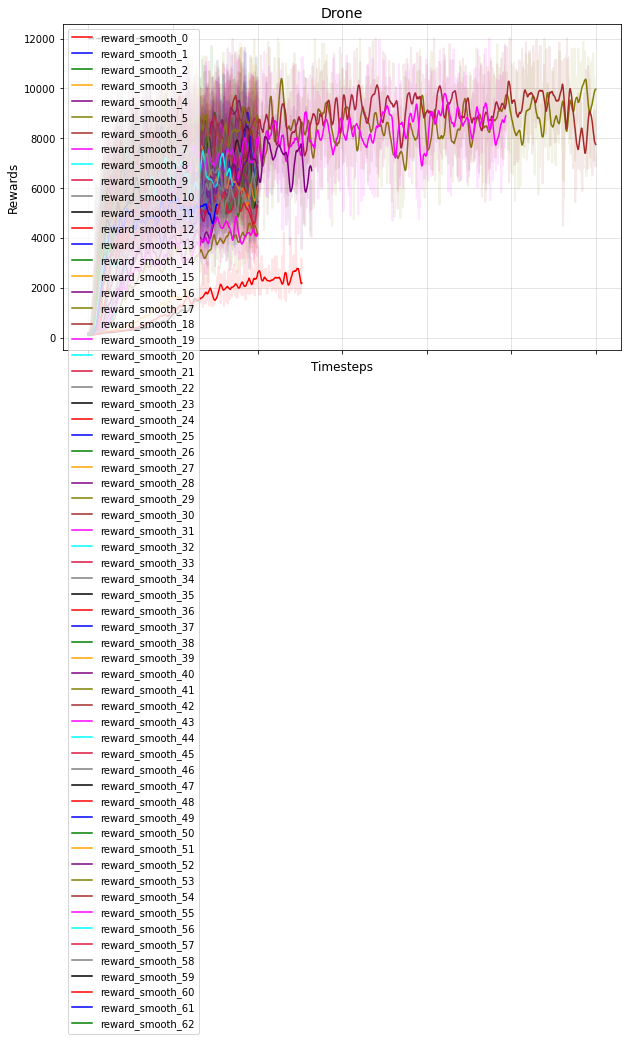

In [10]:
plot_test_results(env_name='Drone')